## Comparison of same strategy between CEX and DEX data

The main purpose of this notebook is to compare the same strategy across two different data sources. If the strategies align closely, this will help affirm that our data is correct. 

Note that we do not expect them to be identical, since naturally CEX and DEX data naturally differs, however it doesn't differ that much (see [this notebook](https://github.com/tradingstrategy-ai/trade-executor/blob/master/notebooks/cex-vs-dex/price-action-difference-eth.ipynb) for more details on this). 

- The DEX data is based on PancakeSwap on BSC chain
- The CEX data is based on Binance data
- The same strategy is used for both sources of data. It is based on fast EMA and slow EMA and depending on the moving average overlap, enters in to a position
- The strategy may or may not generate any profits, as it is not the purpose of this example

* You need a [Trading Strategy API key](https://tradingstrategy.ai/trading-view/backtesting) to run the notebook

## Set up

Set up the parameters used in in this strategy backtest study.

- Backtested blockchain, exchange and trading pair
- Backtesting period
- Strategy parameters for EMA crossovers

In [18]:
import datetime
import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.strategy_module import StrategyType, TradeRouting, ReserveCurrency

# Tell what trade execution engine version this strategy needs to use
# NOTE: this setting has currently no effect
TRADING_STRATEGY_TYPE_ENGINE_VERSION = "0.1"

# What kind of strategy we are running.
# This tells we are going to use
# NOTE: this setting has currently no effect
TRADING_STRATEGY_TYPE = StrategyType.managed_positions

# How our trades are routed.
# PancakeSwap basic routing supports two way trades with BUSD
# and three way trades with BUSD-BNB hop.
TRADE_ROUTING = TradeRouting.pancakeswap_busd

# How often the strategy performs the decide_trades cycle.
# We do it for every 4h.
TRADING_STRATEGY_CYCLE = CycleDuration.cycle_1h

# Strategy keeps its cash in USDC
RESERVE_CURRENCY = ReserveCurrency.busd

# Time bucket for our candles
CANDLE_TIME_BUCKET = TimeBucket.h1

# Which chain we are trading
CHAIN_ID = ChainId.bsc

# Which exchange we are trading on.
EXCHANGE_SLUG = "pancakeswap-v2"

# Which trading pair we are trading
TRADING_PAIR = ("ETH", "USDC")

# How much of the cash to put on a single trade
POSITION_SIZE = 0.70

#
# Strategy thinking specific parameter
#

BATCH_SIZE = 90

SLOW_EMA_CANDLE_COUNT = 10     
FAST_EMA_CANDLE_COUNT = 3


# Range of backtesting and synthetic data generation.
# Because we are using synthetic data actual dates do not really matter -
# only the duration

START_AT = datetime.datetime(2023, 1, 1)

END_AT = datetime.datetime(2024, 1,1)

# Start with 10,000 USD
INITIAL_DEPOSIT = 10_000

# If the price drops 0.7% we trigger a stop loss
STOP_LOSS_PCT = 0.993

STOP_LOSS_TIME_BUCKET = TimeBucket.m15


## Strategy logic and trade decisions

- `decide_trades` function decide what trades to take.
- In this example, we calculate two exponential moving averages
(EMAs) and make decisions based on those.

### Indicators

- Note how we also make use of detached and overlayed technical indicators, so that the price chart is not overcrowded


In [19]:
from typing import List, Dict

from pandas_ta.overlap import ema

from tradeexecutor.state.visualisation import PlotKind, RecordingTime
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pricing_model import PricingModel
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradeexecutor.state.state import State
from tradingstrategy.universe import Universe
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager

def decide_trades(
        timestamp: pd.Timestamp,
        universe: Universe,
        state: State,
        pricing_model: PricingModel,
        cycle_debug_data: Dict) -> List[TradeExecution]:
    """The brain function to decide the trades on each trading strategy cycle.

    - Reads incoming execution state (positions, past trades)

    - Reads the current universe (candles)

    - Decides what trades to do next, if any, at current timestamp.

    - Outputs strategy thinking for visualisation and debug messages

    :param timestamp:
        The Pandas timestamp object for this cycle. Matches
        TRADING_STRATEGY_CYCLE division.
        Always truncated to the zero seconds and minutes, never a real-time clock.

    :param universe:
        Trading universe that was constructed earlier.

    :param state:
        The current trade execution state.
        Contains current open positions and all previously executed trades, plus output
        for statistics, visualisation and diangnostics of the strategy.

    :param pricing_model:
        Pricing model can tell the buy/sell price of the particular asset at a particular moment.

    :param cycle_debug_data:
        Python dictionary for various debug variables you can read or set, specific to this trade cycle.
        This data is discarded at the end of the trade cycle.

    :return:
        List of trade instructions in the form of :py:class:`TradeExecution` instances.
        The trades can be generated using `position_manager` but strategy could also hand craft its trades.
    """

    # The pair we are trading
    pair = universe.pairs.get_single()

    # How much cash we have in the hand
    cash = state.portfolio.get_current_cash()

    # Get OHLCV candles for our trading pair as Pandas Dataframe.
    # We could have candles for multiple trading pairs in a different strategy,
    # but this strategy only operates on single pair candle.
    # We also limit our sample size to N latest candles to speed up calculations.
    candles: pd.DataFrame = universe.candles.get_single_pair_data(timestamp, sample_count=BATCH_SIZE)

    # We have data for open, high, close, etc.
    # We only operate using candle close values in this strategy.
    close_prices = candles["close"]

    # Calculate exponential moving averages based on slow and fast sample numbers.
    slow_ema_series = ema(close_prices, length=SLOW_EMA_CANDLE_COUNT)
    fast_ema_series = ema(close_prices, length=FAST_EMA_CANDLE_COUNT)

    if slow_ema_series is None or fast_ema_series is None:
        # Cannot calculate EMA, because
        # not enough samples in backtesting
        return []

    if len(slow_ema_series) < 2 or len(fast_ema_series) < 2:
        # We need at least two data points to determine if EMA crossover (or crossunder)
        # occurred at current timestamp. 
        return []

    slow_ema_latest = slow_ema_series.iloc[-1]
    fast_ema_latest = fast_ema_series.iloc[-1]
    price_latest = close_prices.iloc[-1]

    # Compute technical indicators needed for trade decisions.
    slow_ema_crossover = (
        close_prices.iloc[-3] < slow_ema_series.iloc[-2]
        and price_latest > slow_ema_latest
    )
    slow_ema_crossunder = (
        close_prices.iloc[-2] > slow_ema_series.iloc[-2]
        and price_latest < slow_ema_latest
    )
    fast_ema_crossunder = (
        close_prices.iloc[-2] > fast_ema_series.iloc[-2]
        and price_latest < fast_ema_latest
    )

#    entry_price = tradeposition.open_price
#    entry_price = float(get_buy_price['amount'])  
    # position_manager = PositionManager(timestamp, universe, state, pricing_model)
    
    trades = []


    # entry_price = position_manager.get_current_position().get_current_price()
    
    # entry_price = tradeexecutor.analysis.trade_analyser.SpotTrade
    
    # List of any trades we decide on this cycle.
    # trades = []

    # Create a position manager helper class that allows us easily to create
    # opening/closing trades for different positions
    position_manager = PositionManager(timestamp, universe, state, pricing_model)

    if not position_manager.is_any_open():
        # No open positions, decide if BUY in this cycle.
        # We buy if we just crossed over the slow EMA or if this is a very first
        # trading cycle and the price is already above the slow EMA.
        if (
            slow_ema_crossunder
            or price_latest < slow_ema_latest and timestamp == START_AT
            ):
            buy_amount = cash * POSITION_SIZE
            new_trades = position_manager.open_1x_long(pair, buy_amount, stop_loss_pct=STOP_LOSS_PCT)
            trades.extend(new_trades)
    else:
        # We have an open position, decide if SELL in this cycle.
        # We do that if we fall below any of the two moving averages.
        if slow_ema_crossover or (fast_ema_crossunder and  fast_ema_latest > slow_ema_latest) :
            new_trades = position_manager.close_all()
            assert len(new_trades) == 1
            trades.extend(new_trades)
                
        #else:
        #    current_position = position_manager.get_current_position()
        #    current_price = current_position.get_current_price()
            #if price_latest <= current_price * STOP_LOSS:
            #    print(f"Stop loss. Now {close}, opened at {entry_price}")
            #    new_trades = position_manager.close_all()
            #    assert len(new_trades) == 1
            #    trades.extend(new_trades)
        
    # Visualize strategy
    # See available Plotly colours here
    # https://community.plotly.com/t/plotly-colours-list/11730/3?u=miohtama
    visualisation = state.visualisation

    # plot stop loss line
    if position_manager.is_any_open():
        stop_loss_usd = position_manager.get_current_position().stop_loss
    else:
        stop_loss_usd = None
    visualisation.plot_indicator(timestamp, "stop loss", PlotKind.technical_indicator_on_price, stop_loss_usd, colour="blue", recording_time=RecordingTime.market_time) 
    
    visualisation.plot_indicator(timestamp, "Fast EMA", PlotKind.technical_indicator_detached, fast_ema_latest, colour="red")
    
    visualisation.plot_indicator(timestamp, "Slow EMA", PlotKind.technical_indicator_overlay_on_detached, slow_ema_latest, colour="green", detached_overlay_name="Fast EMA")
    
    return trades

## Defining the trading universe

We create a trading universe with a single blockchain, exchange and trading pair.
For the sake of easier understanding the code, we name this "Uniswap v2" like exchange with a single ETH-USDC trading pair.

The trading pair contains generated noise-like OHLCV trading data.

In [21]:
from typing import Optional
from tradeexecutor.strategy.trading_strategy_universe import load_pair_data_for_single_exchange, TradingStrategyUniverse
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradingstrategy.client import Client
import datetime

def create_single_pair_trading_universe(
        ts: datetime.datetime,
        client: Client,
        execution_context: ExecutionContext,
        universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    dataset = load_pair_data_for_single_exchange(
        client,
        execution_context,
        CANDLE_TIME_BUCKET,
        CHAIN_ID,
        EXCHANGE_SLUG,
        [TRADING_PAIR],
        universe_options,
        stop_loss_time_bucket=STOP_LOSS_TIME_BUCKET,
    )

    # Filter down to the single pair we are interested in
    universe = TradingStrategyUniverse.create_single_pair_universe(
        dataset,
        CHAIN_ID,
        EXCHANGE_SLUG,
        TRADING_PAIR[0],
        TRADING_PAIR[1],
    )

    return universe

## Set up the market data client

The [Trading Strategy market data client](https://tradingstrategy.ai/docs/programming/api/client/index.html)
is the Python library responsible for managing the data feeds needed to run the backtest.None

We set up the market data client with an API key.

[If you do not have an API key yet, you can register one](https://tradingstrategy.ai/trading-view/backtesting).

In [22]:
from tradingstrategy.client import Client

client = Client.create_jupyter_client()
binance_client = Client.create_jupyter_client()

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/alexurbs/.tradingstrategy
Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/alexurbs/.tradingstrategy


## Load data

In [27]:
from tradeexecutor.strategy.execution_context import ExecutionMode
from tradeexecutor.strategy.universe_model import UniverseOptions

universe = create_single_pair_trading_universe(
    END_AT,
    client,
    ExecutionContext(mode=ExecutionMode.data_preload),
    UniverseOptions()
)
print(f"We loaded {universe.universe.candles.get_candle_count():,} candles.")

Loading OHLCV data for ETH-USDC:   0%|          | 0/85351546 [00:00<?, ?it/s]

We loaded 22,751 candles.


## Binance Universe

Since it is long only, we set `include_lending=False`

### Setting the fee

**NB** if you don't make sure the same fee tiers are used, the results can be vastly different! Try changing the fee here to 0.0005 (0.05%) and see what happens

In [24]:
from tradeexecutor.utils.binance import create_binance_universe

binance_universe = create_binance_universe(
    ["ETHUSDT"],
    CANDLE_TIME_BUCKET,
    CANDLE_TIME_BUCKET,
    fee=0.0025,
    start_at=START_AT - datetime.timedelta(days=BATCH_SIZE + 10),
    end_at=END_AT,
    include_lending=False,
    force_download=True,
)

print(f"We loaded {binance_universe.universe.candles.get_candle_count():,} candles.")

  0%|          | 0/1 [00:00<?, ?it/s]

We loaded 11,185 candles.


In [25]:
traded_pair = universe.universe.pairs.get_single()
binance_traded_pair = binance_universe.universe.pairs.get_single()

assert traded_pair.fee == binance_traded_pair.fee, f"fees should match, {traded_pair.fee} vs {binance_traded_pair.fee}"

## Run backtest with DEX data

Run backtest using giving trading universe and strategy function.

- Running the backtest outputs `state` object that contains all the information
on the backtesting position and trades.
- The trade execution engine will download the necessary datasets to run the backtest.
  The datasets may be large, several gigabytes.


In [26]:
import logging

from tradeexecutor.backtest.backtest_runner import run_backtest_inline

state, universe, debug_dump = run_backtest_inline(
    name="ETH/USDC fast and slow EMA example",
    start_at=START_AT,
    end_at=END_AT,
    client=client,
    cycle_duration=TRADING_STRATEGY_CYCLE,
    decide_trades=decide_trades,
    universe=universe,
    # create_trading_universe=create_single_pair_trading_universe,
    initial_deposit=INITIAL_DEPOSIT,
    reserve_currency=RESERVE_CURRENCY,
    trade_routing=TRADE_ROUTING,
    log_level=logging.WARNING,
)

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

  0%|          | 0/31536000 [00:00<?, ?it/s]

AutoClosingOrderUnsupported: Trade was marked with stop loss/take profit even though backtesting trading universe does not have price feed for stop loss checks available.
Remember to use the stop_loss_time_bucket parameter or equivalent when you create your trading universe to avoid this error.

## Run backtest with Binance data

In [ ]:
binance_state, binance_universe, binance_debug_dump = run_backtest_inline(
    name="ETH/USDC fast and slow EMA example with Binance data",
    start_at=START_AT,
    end_at=END_AT,
    client=binance_client,
    cycle_duration=TRADING_STRATEGY_CYCLE,
    decide_trades=decide_trades,
    universe=binance_universe,
    # create_trading_universe=create_single_pair_trading_universe,
    initial_deposit=INITIAL_DEPOSIT,
    reserve_currency=RESERVE_CURRENCY,
    trade_routing=TRADE_ROUTING,
    log_level=logging.WARNING,
)

trade_count = len(list(binance_state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

  0%|          | 0/63072000 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 3113 trades


## Examine backtest results

Examine `state` that contains all actions the trade executor took.

We plot out a chart that shows
- The price action
- When the strategy made buys or sells

In [ ]:
traded_pair = universe.universe.pairs.get_single()
binance_traded_pair = binance_universe.universe.pairs.get_single()

print(f"Positions taken: {len(list(state.portfolio.get_all_positions()))}")
print(f"Trades made: {len(list(state.portfolio.get_all_trades()))}")

Positions taken: 1315
Trades made: 2629


In [ ]:
print(f"Positions taken: {len(list(binance_state.portfolio.get_all_positions()))}")
print(f"Trades made: {len(list(binance_state.portfolio.get_all_trades()))}")

Positions taken: 1557
Trades made: 3113


## Candle charts

In the candle charts below, we have only shown the last 50 days of the strategy, although in total it ran for 2 years.

The candle charts show that the price action is very similar between the two datasets. However, it's hard to compare strategy trading results visually so hopefully the summary statistics will give us a better idea.

The right y-axis of the charts show that Binance has much higher volume than Pancakeswap, as expected.

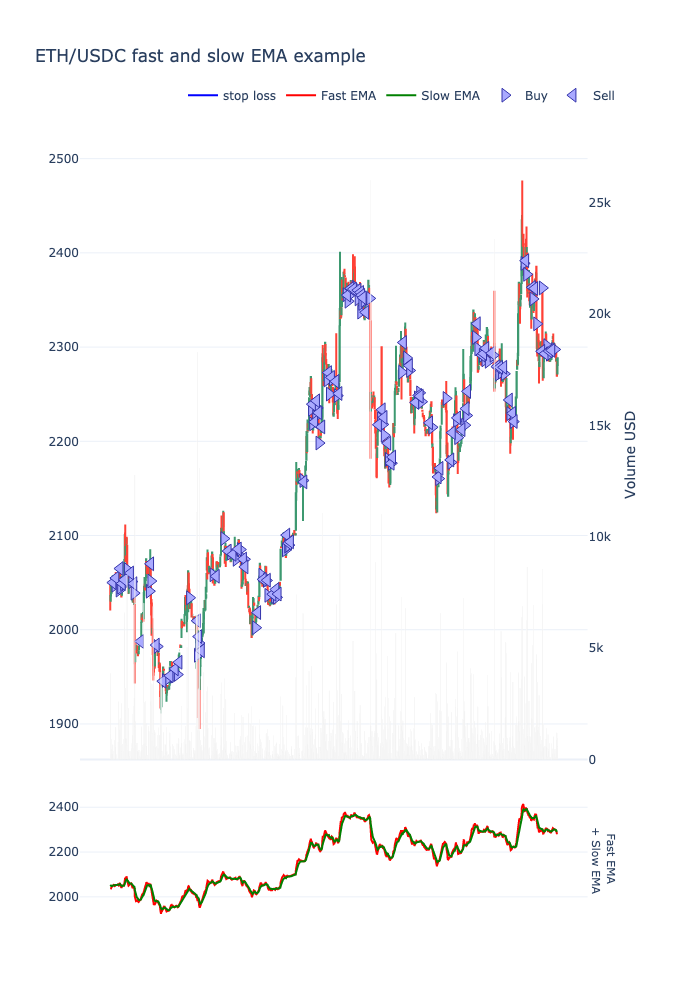

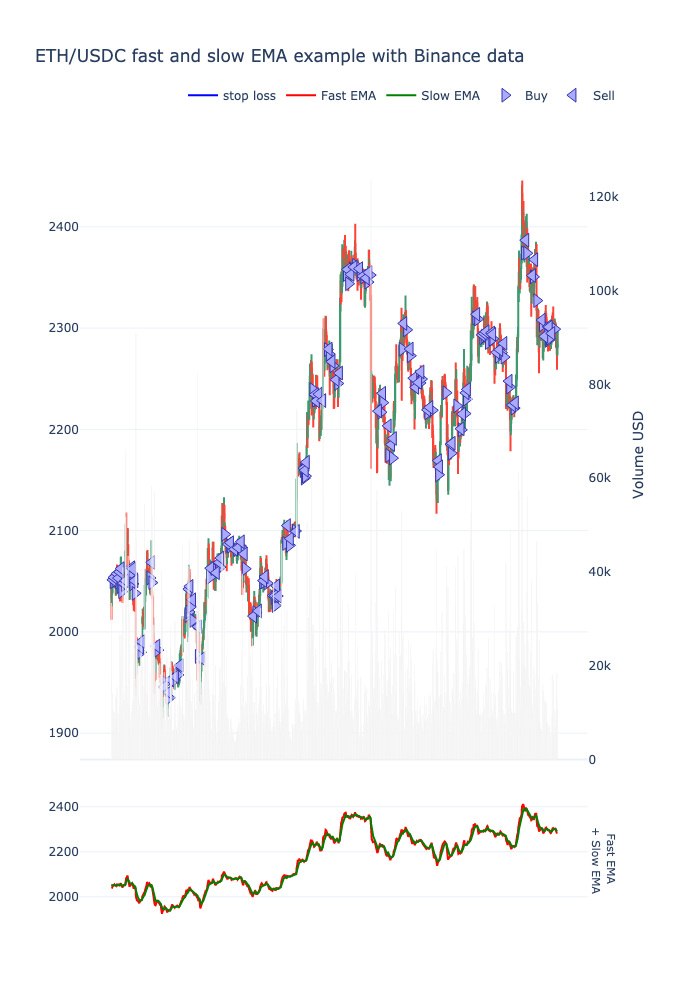

In [ ]:

from tradeexecutor.visual.single_pair import visualise_single_pair

figure = visualise_single_pair(
    state,
    universe.universe.candles,
    start_at=END_AT - datetime.timedelta(days=50),
    end_at=END_AT,
    height = 1000,
)

figure.show('png')

binance_figure = visualise_single_pair(
    binance_state,
    binance_universe.universe.candles,
    start_at=END_AT - datetime.timedelta(days=50),
    end_at=END_AT,
    height = 1000,
)

binance_figure.show('png')

## Benchmarking the strategy performance

The benchmarks between the Binance and DEX data look very similar at first glance. Ignore the poor performance of the strategy as this was not the goal of this particular notebook.

In [ ]:
from tradeexecutor.visual.benchmark import visualise_benchmark

fig = visualise_benchmark(
    state.name,
    portfolio_statistics=state.stats.portfolio,
    all_cash=state.portfolio.get_initial_deposit(),
    buy_and_hold_asset_name=traded_pair.base_token_symbol,
    buy_and_hold_price_series=universe.universe.candles.get_single_pair_data()["close"],
    start_at=START_AT,
    end_at=END_AT,
    height=800
)

fig.show()

fig = visualise_benchmark(
    binance_state.name,
    portfolio_statistics=binance_state.stats.portfolio,
    all_cash=binance_state.portfolio.get_initial_deposit(),
    buy_and_hold_asset_name=binance_traded_pair.base_token_symbol,
    buy_and_hold_price_series=binance_universe.universe.candles.get_single_pair_data()["close"],
    start_at=START_AT,
    end_at=END_AT,
    height=800
)

fig.show()

## Analysing  the strategy success

Here we calculate statistics on how well the strategy performed.

- Won/lost trades
- Timeline of taken positions with color coding of trade performance


In [ ]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)
binance_analysis = build_trade_analysis(binance_state.portfolio)

### Strategy comparison summary

The best point of comparison between the Binance and Dex strategy will be the side-by-side statistics tables. Here, we see a wide variety of similarities and differences between the two sources of data.

- As expected, the returns between the two strategies are similar (-89.76% vs -91,96%). This confirms the data and strategies are working as expected. 
- It becomes clear that there are some notable differences between the strategies, specifcally the number of positions. 





In [ ]:
from IPython.core.display_functions import display
from IPython.display import display_html 

summary = analysis.calculate_summary_statistics(state=state, time_bucket=CANDLE_TIME_BUCKET)
binance_summary = binance_analysis.calculate_summary_statistics(state=binance_state, time_bucket=CANDLE_TIME_BUCKET)

df1 = summary.to_dataframe(format_headings=False)
df2 = binance_summary.to_dataframe(format_headings=False)

df1_styler = df1.style.set_table_attributes("style='display:inline'")
df2_styler = df2.style.set_table_attributes("style='display:inline'")

display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)

0 
 
 
 
 
 Trading period length 
 729 days 16 hours 
 
 
 Return % 
 -99.46% 
 
 
 Annualised return % 
 -49.75% 
 
 
 Cash at start 
 $10,000.00 
 
 
 Value at end 
 $53.81 
 
 
 Trade volume 
 $3,583,753.80 
 
 
 Position win percent 
 29.30% 
 
 
 Total positions 
 1314 
 
 
 Won positions 
 385 
 
 
 Lost positions 
 929 
 
 
 Stop losses triggered 
 0 
 
 
 Stop loss % of all 
 0.00% 
 
 
 Stop loss % of lost 
 0.00% 
 
 
 Winning stop losses 
 0 
 
 
 Winning stop losses percent 
 - 
 
 
 Losing stop losses 
 0 
 
 
 Losing stop losses percent 
 - 
 
 
 Take profits triggered 
 0 
 
 
 Take profit % of all 
 0.00% 
 
 
 Take profit % of won 
 0.00% 
 
 
 Zero profit positions 
 0 
 
 
 Positions open at the end 
 1 
 
 
 Realised profit and loss 
 $-9,945.58 
 
 
 Unrealised profit and loss 
 $-0.61 
 
 
 Portfolio unrealised value 
 $37.48 
 
 
 Extra returns on lending pool interest 
 $0.00 
 
 
 Cash left at the end 
 $16.33 
 
 
 Average winning position profit % 
 0.84% 
 
 
 Average losing position loss % 
 -1.13% 
 
 
 Biggest winning position % 
 7.38% 
 
 
 Biggest losing position % 
 -24.28% 
 
 
 Average duration of winning positions 
 3 hours 15 minutes 
 
 
 Average duration of losing positions 
 8 hours 21 minutes 
 
 
 Average bars of winning positions 
 3 bars 
 
 
 Average bars of losing positions 
 8 bars 
 
 
 LP fees paid 
 $8,970.58 
 
 
 LP fees paid % of volume 
 0.25% 
 
 
 Average position 
 -0.55% 
 
 
 Median position 
 -0.31% 
 
 
 Most consecutive wins 
 7 
 
 
 Most consecutive losses 
 38 
 
 
 Biggest realised risk 
 -17.00% 
 
 
 Avg realised risk 
 -0.79% 
 
 
 Max pullback of total capital 
 -28.93% 
 
 
 Max loss risk at opening of position 
 70.00% 
 
 
 Max drawdown 
 -99.47% 
 
 
 

 
 
 
   
 0 
 
 
 
 
 Trading period length 
 729 days 16 hours 
 
 
 Return % 
 -99.59% 
 
 
 Annualised return % 
 -49.82% 
 
 
 Cash at start 
 $10,000.00 
 
 
 Value at end 
 $40.53 
 
 
 Trade volume 
 $3,780,650.10 
 
 
 Position win percent 
 27.44% 
 
 
 Total positions 
 1556 
 
 
 Won positions 
 427 
 
 
 Lost positions 
 1129 
 
 
 Stop losses triggered 
 0 
 
 
 Stop loss % of all 
 0.00% 
 
 
 Stop loss % of lost 
 0.00% 
 
 
 Winning stop losses 
 0 
 
 
 Winning stop losses percent 
 - 
 
 
 Losing stop losses 
 0 
 
 
 Losing stop losses percent 
 - 
 
 
 Take profits triggered 
 0 
 
 
 Take profit % of all 
 0.00% 
 
 
 Take profit % of won 
 0.00% 
 
 
 Zero profit positions 
 0 
 
 
 Positions open at the end 
 1 
 
 
 Realised profit and loss 
 $-9,959.03 
 
 
 Unrealised profit and loss 
 $-0.44 
 
 
 Portfolio unrealised value 
 $28.24 
 
 
 Extra returns on lending pool interest 
 $0.00 
 
 
 Cash left at the end 
 $12.29 
 
 
 Average winning position profit % 
 0.77% 
 
 
 Average losing position loss % 
 -0.97% 
 
 
 Biggest winning position % 
 7.49% 
 
 
 Biggest losing position % 
 -22.44% 
 
 
 Average duration of winning positions 
 3 hours 5 minutes 
 
 
 Average duration of losing positions 
 7 hours 0 minutes 
 
 
 Average bars of winning positions 
 3 bars 
 
 
 Average bars of losing positions 
 7 bars 
 
 
 LP fees paid 
 $9,463.44 
 
 
 LP fees paid % of volume 
 0.25% 
 
 
 Average position 
 -0.49% 
 
 
 Median position 
 -0.28% 
 
 
 Most consecutive wins 
 8 
 
 
 Most consecutive losses 
 24 
 
 
 Biggest realised risk 
 -15.71% 
 
 
 Avg realised risk 
 -0.68% 
 
 
 Max pullback of total capital 
 -29.29% 
 
 
 Max loss risk at opening of position 
 70.00% 
 
 
 Max drawdown 
 -99.60%

## Finishing notes

Print out a line to signal the notebook finished the execution successfully.

In [ ]:
print("All ok")

All ok
